In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import glob

matplotlib.rc('font', family='Times')
matplotlib.rcParams.update({'font.size': 14})
from matplotlib.colors import LogNorm

In [2]:
class Message(object):
    def __init__(self, msg_id, orig_msg_id, who_posted, who_originated, opinion, temperature):
        self.msg_id = msg_id
        self.orig_msg_id = orig_msg_id
        self.who_posted = who_posted
        self.who_originated = who_originated
        self.opinion = opinion
        self.temperature = temperature


    def to_dict(self):
        return {'msg_id': self.msg_id, 
                'orig_msg_id':self.orig_msg_id,
                'who_posted':self.who_posted,
                'who_originated':self.who_originated,
                'opinion':self.opinion,
                'temperature':self.temperature}


class Agent(object):
    def __init__(self, user_id, epsilon, delta):
        self.user_id = user_id
        self.opinion = np.random.uniform(-1.0, 1.0)
        self.epsilon = epsilon
        self.temperature = np.random.uniform(0, 1.0)
        self.delta = delta
        self.orig_msg_ids_in_screen = []


    def set_orig_msg_ids_in_screen(self, screen):
        self.orig_msg_ids_in_screen = screen.orig_msg_id.values


    def evaluate_messages(self, screen):
        self.concordant_msgs = []
        self.discordant_msgs = []

        if len(screen) > 0:
            opinion_filter_close_opinion = abs(self.opinion - screen.opinion) < self.epsilon
            opinion_filter_far_opinion = abs(self.opinion - screen.opinion) >= self.epsilon
            temperature_filter = screen.temperature <= self.delta
            #temperature_filter_close_opinion = screen.temperature - self.temperature <= self.delta
            #temperature_filter_far_opinion = screen.temperature + self.temperature <= self.delta
            self.concordant_msgs = screen[opinion_filter_close_opinion & temperature_filter]
            self.discordant_msgs = screen.drop(self.concordant_msgs.index)


    def update_opinion(self, mu):
        if len(self.concordant_msgs) > 0:
            self.opinion = self.opinion + mu * np.mean(self.concordant_msgs.opinion - self.opinion)


    def update_temperature(self, screen, beta):
        if len(screen) > 0:
            self.temperature = beta * self.temperature + (1-beta) * np.mean(screen.temperature)


    def post_message(self, msg_id, p):
        if len(self.concordant_msgs) > 0 and np.random.random() < p:
            # repost a friend's message selected at random
            idx = np.random.choice(self.concordant_msgs.index)
            selected_msg = self.concordant_msgs.loc[idx]
            return Message(msg_id=int(msg_id), 
                           orig_msg_id=int(selected_msg.orig_msg_id),
                           who_posted=int(self.user_id), 
                           who_originated=int(selected_msg.who_originated),
                           opinion=selected_msg.opinion,
                           temperature=selected_msg.temperature)
        else:
            # post a new message
            new_opinion = self.opinion
            new_temperature = self.temperature
            return Message(msg_id=int(msg_id),
                           orig_msg_id=int(msg_id),
                           who_posted=int(self.user_id),
                           who_originated=int(self.user_id),
                           opinion=new_opinion,
                           temperature=new_temperature)


    def decide_follow_id_at_random(self, friends, num_agents):
        prohibit_list = list(friends) + [self.user_id]
        return int(np.random.choice([i for i in range(num_agents) if i not in prohibit_list]))


    def decide_unfollow_id_at_random(self, discordant_messages):
        unfollow_candidates = discordant_messages.who_posted.values
        return int(np.random.choice(unfollow_candidates))


    def decide_to_rewire(self, social_media, following_methods):
        unfollow_id = None
        follow_id = None

        if len(self.discordant_msgs) > 0:
            # decide whom to unfollow
            unfollow_id = self.decide_unfollow_id_at_random(self.discordant_msgs)
            # decide whom to follow
            following_method = np.random.choice(following_methods)
            friends = social_media.G.neighbors(self.user_id)
            friends = list(friends)

            # Repost-based selection if possible; otherwise random selection
            if following_method == 'Repost':
                friends_of_friends = list(set(self.concordant_msgs.who_originated.values) - set(friends))
                if len(friends_of_friends) > 0:
                    follow_id = int(np.random.choice(friends_of_friends))
                else:
                    follow_id = self.decide_follow_id_at_random(friends, social_media.G.number_of_nodes())

            # Recommendation-based selection if possible; otherwise random selection
            elif following_method == 'Recommendation':
                similar_agents = social_media.recommend_similar_users(self.user_id, self.epsilon, social_media.G.number_of_nodes())
                if len(similar_agents) > 0:
                    follow_id = int(np.random.choice(similar_agents))
                else:
                    follow_id = self.decide_follow_id_at_random(friends, social_media.G.number_of_nodes())

            # Random selection
            else:
                follow_id = self.decide_follow_id_at_random(friends, social_media.G.number_of_nodes())

        return unfollow_id, follow_id

In [3]:
class SocialMedia(object):
    def __init__(self, num_agents, num_links, l, sns_seed):
        self.num_agents = num_agents
        random_state = np.random.RandomState(sns_seed)
        self.G = nx.gnm_random_graph(n=num_agents, m=num_links, seed=random_state, directed=True)
        self.modify_random_graph()
        self.message_dic = {}
        self.message_df = pd.DataFrame(columns=['msg_id', 'orig_msg_id', 'who_posted', 'who_originated', 'opinion'])
        self.screen_size = l


    def modify_random_graph(self):
        for no_outdegree_node in [k for k, v in list(self.G.out_degree()) if v == 0]:
            target_node = np.random.choice([k for k, v in list(self.G.out_degree()) if v >= 2])
            i = np.random.choice(len(self.G.edges(target_node)))
            target_edge = list(self.G.edges(target_node))[i]
            self.G.remove_edge(target_edge[0], target_edge[1])
            self.G.add_edge(no_outdegree_node, target_edge[1])


    def set_node_colors(self, node_colors):
        for i, c in enumerate(node_colors):
            self.G.nodes[i]['color'] = c


    def show_screen(self, user_id):
        friends = self.G.neighbors(user_id)
        friend_message_df = self.message_df[self.message_df['who_posted'].isin(friends)]
        friend_message_df = friend_message_df[friend_message_df['who_originated'] != user_id]
        return friend_message_df.tail(self.screen_size)


    def update_message_db(self, t, msg):
        self.message_df = pd.concat([self.message_df, pd.DataFrame([msg.to_dict()])])
        self.message_df.reset_index(drop=True, inplace=True)
        #self.message_df = self.message_df.append(msg.to_dict(), ignore_index=True).tail(self.num_agents)
        

    def recommend_similar_users(self, user_id, epsilon, num_agents):
        similar_users = []
        my_message_df = self.message_df[self.message_df.who_originated == user_id].tail(1)

        if len(my_message_df) > 0:
            last_message = my_message_df.opinion.values[0]
            friends = self.G.neighbors(user_id)
            friends = list(friends)
            similar_messages_df = self.message_df[self.message_df.who_originated != user_id].tail(num_agents)
            similar_messages_df = similar_messages_df[abs(last_message - similar_messages_df.opinion) < epsilon]
            if len(similar_messages_df) > 0:
                similar_users = [u for u in similar_messages_df.who_originated.values if u not in friends]

        return similar_users


    def rewire_users(self, user_id, unfollow_id, follow_id):
        self.G.remove_edge(user_id, unfollow_id)
        self.G.add_edge(user_id, follow_id)

In [4]:
class EchoChamberDynamics(object):
    def __init__(self, num_agents, num_links, epsilon, delta, sns_seed, l):
        self.num_agents = num_agents
        self.l = l
        self.epsilon = epsilon
        self.delta = delta
        self.set_agents(num_agents, epsilon, delta)
        self.social_media = SocialMedia(num_agents, num_links, l, sns_seed)
        self.opinion_data = []
        self.linkage_analysis_log = []


    def set_agents(self, num_agents, epsilon, delta):
        self.agents = [Agent(i, epsilon, delta) for i in range(num_agents)]


    def total_discordant_messages(self):
        total_discordant_msgs = 0
        for a in self.agents:
            total_discordant_msgs += len(a.discordant_msgs)
        return total_discordant_msgs


    def is_stationary_state(self, G):
        num_clusters = len([G.subgraph(c) for c in nx.weakly_connected_components(G)])
        num_converged_clusters = 0

        if num_clusters >= 2:
            for C in [G.subgraph(c) for c in nx.weakly_connected_components(G)]:
                _agents = [self.agents[i] for i in list(C.nodes())]
                opinions = np.array([a.opinion for a in _agents])
                opi_diff = np.max(opinions) - np.min(opinions)
                if opi_diff <= self.epsilon:
                    num_converged_clusters += 1

        if num_converged_clusters == num_clusters:
            return True
        else:
            return False

        
    def willingness_to_listen(self):

        G = self.social_media.G
        opinions = [self.agents[i].opinion for i in range(N)]
        temperatures = [self.agents[i].temperature for i in range(N)]

        low_temp_agents = np.where(np.array(temperatures)<=self.delta)[0] # list of users having a "low temperature"

        linkage_analysis = {}

        for node, opinion in enumerate(opinions):

            linkage_analysis[node] = {'potential_but_not_following':0, 'potential_and_following':0, 
                                      'not_potential_and_following':0, 'out_degree':None, 'in_degree':None}

            for low_temp_agent in low_temp_agents:
                if node == low_temp_agent:
                    continue

                opinion_low_temp_agent = opinions[low_temp_agent]
                op_diff = abs(opinion_low_temp_agent - opinion)
                is_neighbor = low_temp_agent in [*G.neighbors(node)]

                if (not is_neighbor) & (op_diff < self.epsilon):
                    linkage_analysis[node]['potential_but_not_following'] += 1

                if (is_neighbor) & (op_diff < self.epsilon):
                    linkage_analysis[node]['potential_and_following'] += 1

            linkage_analysis[node]['out_degree'] = G.out_degree[node]
            linkage_analysis[node]['in_degree'] = G.in_degree[node]

            linkage_analysis[node]['not_potential_and_following'] = linkage_analysis[node]['out_degree'] - linkage_analysis[node]['potential_and_following']

        return linkage_analysis

    def external_shock(self, magnitude, ratio_affected_agents):
        count_affected_agents = round(self.num_agents * ratio_affected_agents)
        affected_agents = np.random.choice([*range(count_affected_agents)], size=count_affected_agents)
        #affected_agents = [*range(count_affected_agents)][:count_affected_agents]

        for user_id in affected_agents:
            self.agents[user_id].temperature += magnitude

            # correction if above 1
            if self.agents[user_id].temperature > 1:
                self.agents[user_id].temperature = 1


    def cool_down(self, magnitude):

        for user_id in range(self.num_agents):
            self.agents[user_id].temperature -= magnitude

            # correction if below 0
            if self.agents[user_id].temperature < 0:
                self.agents[user_id].temperature = 0


    def evolve(self, t_max, mu, p, q, beta, magnitude, ratio_affected_agents, rewiring_methods):

        for t in range(t_max):

            #self.screen_diversity_data.append([a.screen_diversity for a in self.agents])

            # calm everyone down
            #self.cool_down(0.00001)

            # export network data
            #if t % 1000 == 0:
                #print("Iteration:", t)
                #print("Avg. temp:", np.mean([a.temperature for a in ecd.agents]))
                #print("Std. temp:", np.std([a.temperature for a in ecd.agents]))
                #print("Avg. opinion:", np.mean([a.opinion for a in ecd.agents]))
                #print("Std. opinion:", np.std([a.opinion for a in ecd.agents]))
                #print("Before shock:", np.mean([a.temperature for a in ecd.agents]))
                #self.external_shock(magnitude, ratio_affected_agents)
                #print("After shock:", np.mean([a.temperature for a in ecd.agents]))
                #print()

            # select agent i at random
            user_id = np.random.choice(self.num_agents)

            # agent i refleshes its screen and reading it
            screen = self.social_media.show_screen(user_id)
            self.agents[user_id].evaluate_messages(screen)

            # social influence (mu)
            unfollow_id = None
            follow_id = None
            self.agents[user_id].update_opinion(mu)

            # update the temperature
            # self.agents[user_id].update_temperature(screen, beta)

            # rewiring (q)
            if np.random.random() < q:
                unfollow_id, follow_id = self.agents[user_id].decide_to_rewire(self.social_media, rewiring_methods)
                if unfollow_id is not None and follow_id is not None:
                    self.social_media.rewire_users(user_id, unfollow_id, follow_id)

            # log agent opinions
            curr_opinion = np.array([a.opinion for a in self.agents])
            self.opinion_data.append(curr_opinion)
            
            # post (1-p) or repost (p) a message 
            msg = self.agents[user_id].post_message(t, p)
            self.social_media.update_message_db(t, msg)
            
            if t % 1000 == 0:
                print("Iteration:", t)            
                linkage_analysis = self.willingness_to_listen()
                self.linkage_analysis_log.append(linkage_analysis)

            # if the maximum opinion difference is lower than the epsilon for the last "number of agents" iterations, break the loop
            # the intuition is that we give everyone a turn to change their ideas, they haven't changed at all.

            #if t != 0:
            #    if t % self.num_agents == 0:
            #        past_opinions = (self.opinion_data[-self.num_agents])
            #        opi_diff = max(curr_opinion - past_opinions)
            #        if max(curr_opinion - past_opinions) < self.epsilon:
            #            break
                        
            # finalize and export data            
            if self.is_stationary_state(self.social_media.G):
                break

            if t >= t_max - 1:
                break

In [ ]:
N = 100
log = {}
delta_vals = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
#delta_vals = [.2]

for delta in delta_vals:
    print("DELTA:", delta)
    log
    for i in range(10):
        N = N
        E = 400
        epsilon = .4
        delta = delta
        sns_seed = 1 #np.random.randint(0, 100000)
        l = 10

        ecd = EchoChamberDynamics(num_agents = N,
                                  num_links = E,
                                  epsilon = epsilon,
                                  delta = delta,
                                  sns_seed = sns_seed,
                                  l = l)

        t_max = 100000
        mu = .5
        p = .5
        q = .5
        beta = .5

        magnitude = .8
        ratio_affected_agents = .2

        rewiring_methods = ['Random']

        ecd.evolve(t_max, mu, p, q, beta, magnitude, ratio_affected_agents, rewiring_methods)

        if log.get(delta) == None:
            log[delta] = {}

        log[delta][i] = {}
        log[delta][i]['opinions'] = [ecd.agents[i].opinion for i in range(N)]
        log[delta][i]['temperature'] = [ecd.agents[i].temperature for i in range(N)]
        log[delta][i]['network'] = ecd.social_media.G
        log[delta][i]['opinion_data'] = ecd.opinion_data
        log[delta][i]['linkage_analysis'] = ecd.linkage_analysis_log

DELTA: 0
Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000
Iteration: 32000
Iteration: 33000
Iteration: 34000
Iteration: 35000
Iteration: 36000
Iteration: 37000
Iteration: 38000
Iteration: 39000
Iteration: 40000
Iteration: 41000
Iteration: 42000
Iteration: 43000
Iteration: 44000
Iteration: 45000
Iteration: 46000
Iteration: 47000
Iteration: 48000
Iteration: 49000
Iteration: 50000
Iteration: 51000
Iteration: 52000
Iteration: 53000
Iteration: 54000
Iteration: 55000
Iteration: 56000
Iteration: 57000
Iteration: 58000
I

In [250]:
[[v['potential_and_following']/v['out_degree'] for v in ecd.linkage_analysis_log[i].values()] for i in range(10)]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.25,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.0,
  0.0,
  0.0,
  0.0,
  0.3333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2857142857142857,
  0.0,
  0.0,
  0.25,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1111111111111111,
  0.0,
  0.14285714285714285,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.0,
  0.2,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.0,
  0.0,
  0.3333333333333333,
  0.3333333333333333,
  0.0,
  0.0,
  0.2,
  0.16666666666666666,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.0,
  0.16666666666666666,
  0.0,
  0.0,
  0.2857142857142857,
  0.0,
  0.0],
 [0.2,
  0.5,
  0.0,
  0.5,
  0.0,
  0.0,
  0.0,
  0.2,
  0.25,
  0.0,
  0.2,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.2857142857142857,
  0.3333333333333333,
  

In [12]:
import json

In [253]:
# "jsonify" the np arrays
for delta in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    for s in range(10):
        log[delta][s]['opinion_data'] = np.array(log[delta][s]['opinion_data']).tolist()

# Serializing json
json_object = json.dumps({k:{k_:{k__:v__ for k__,v__ in v_.items() if k__!='network'} for k_,v_ in v.items()} for k,v in log.items()}, indent=4)

#Writing to sample.json
with open("../../data/log_dont_listen_high_temp.json", "w") as outfile:
    outfile.write(json_object)

In [14]:
#with open("../../data/log_dont_listen_high_temp.json", "r") as f:
#    log = json.load(f)

### **Neighbors that the agent is willing to listen to**

In [301]:
low_temp_agents = np.where(np.array(log[delta][i]['temperature'])<=.2)[0]
high_temp_agents = np.where(np.array(log[delta][i]['temperature'])>.2)[0]

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_31867/1495759205.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


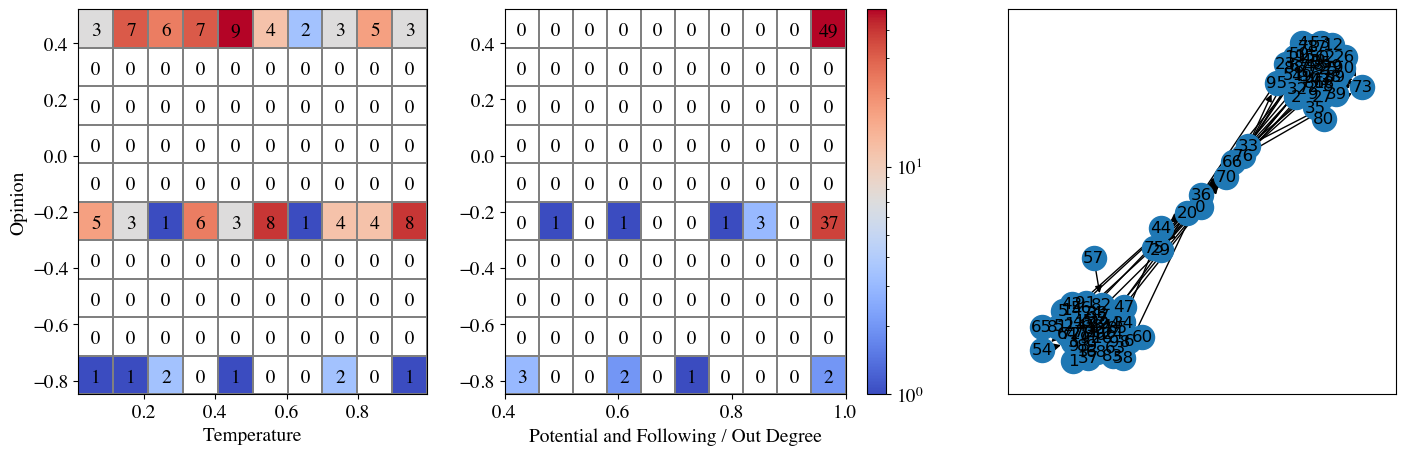

In [405]:
fig, axs = plt.subplots(1,3,figsize=(17,5), width_ratios=(.9,1.1,1))
delta = .5
i = 5
linkage_analysis = log[delta][i]['linkage_analysis']
temperatures = log[delta][i]['temperature']
opinions = log[delta][i]['opinions']
G = log[delta][i]['network']

hist, xbins, ybins, im = axs[0].hist2d(temperatures,
                                       opinions,
                                       norm=LogNorm(),
                                       edgecolor='gray',
                                       linewidth=1.2,
                                       cmap='coolwarm')
axs[0].set_xlabel('Temperature')
axs[0].set_ylabel('Opinion')

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        axs[1].text(xbins[j]+.05, ybins[i]+.06, int(hist.T[i,j]), 
                    color="black", ha="center", va="center", fontweight="bold",
                    transform=axs[0].transData)
        
#
hist, xbins, ybins, im = axs[1].hist2d([v['potential_and_following']/v['out_degree'] for v in linkage_analysis[-1].values()],
                                       opinions,
                                       norm=LogNorm(),
                                       edgecolor='gray',
                                       linewidth=1.2,
                                       cmap='coolwarm')
axs[1].set_xlabel('Potential and Following / Out Degree')

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        axs[1].text(xbins[j]+.03,ybins[i]+.06, int(hist.T[i,j]), 
                    color="black", ha="center", va="center", fontweight="bold",
                    transform=axs[1].transData)

fig.colorbar(im, ax=axs[1])

nx.draw_networkx(G,
                 ax=axs[2])

fig.show()

In [428]:
node = 66
print('Neighbors:',[*G.neighbors(node)])
print('Out-degree:',G.out_degree(node))
print('Temperature:',temperatures[node])
print('Opinion:',opinions[node])
print('Not willing to listen but following:',linkage_analysis[-1][node]['not_potential_and_following'])
print('Potential and Following / Out Degree:',linkage_analysis[-1][node]['potential_and_following']/linkage_analysis[-1][node]['out_degree'])
print('Potential but not following:',linkage_analysis[-1][node]['potential_but_not_following'])

Neighbors: [36, 29, 70, 48]
Out-degree: 4
Temperature: 0.43615925371887665
Opinion: -0.8493379998678126
Not willing to listen but following: 1
Potential and Following / Out Degree: 0.75
Potential but not following: 1


In [ ]:
row_col = []
for row in range(5):
    for col in range(5):
        row_col.append((row,col))

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_31867/2664605465.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


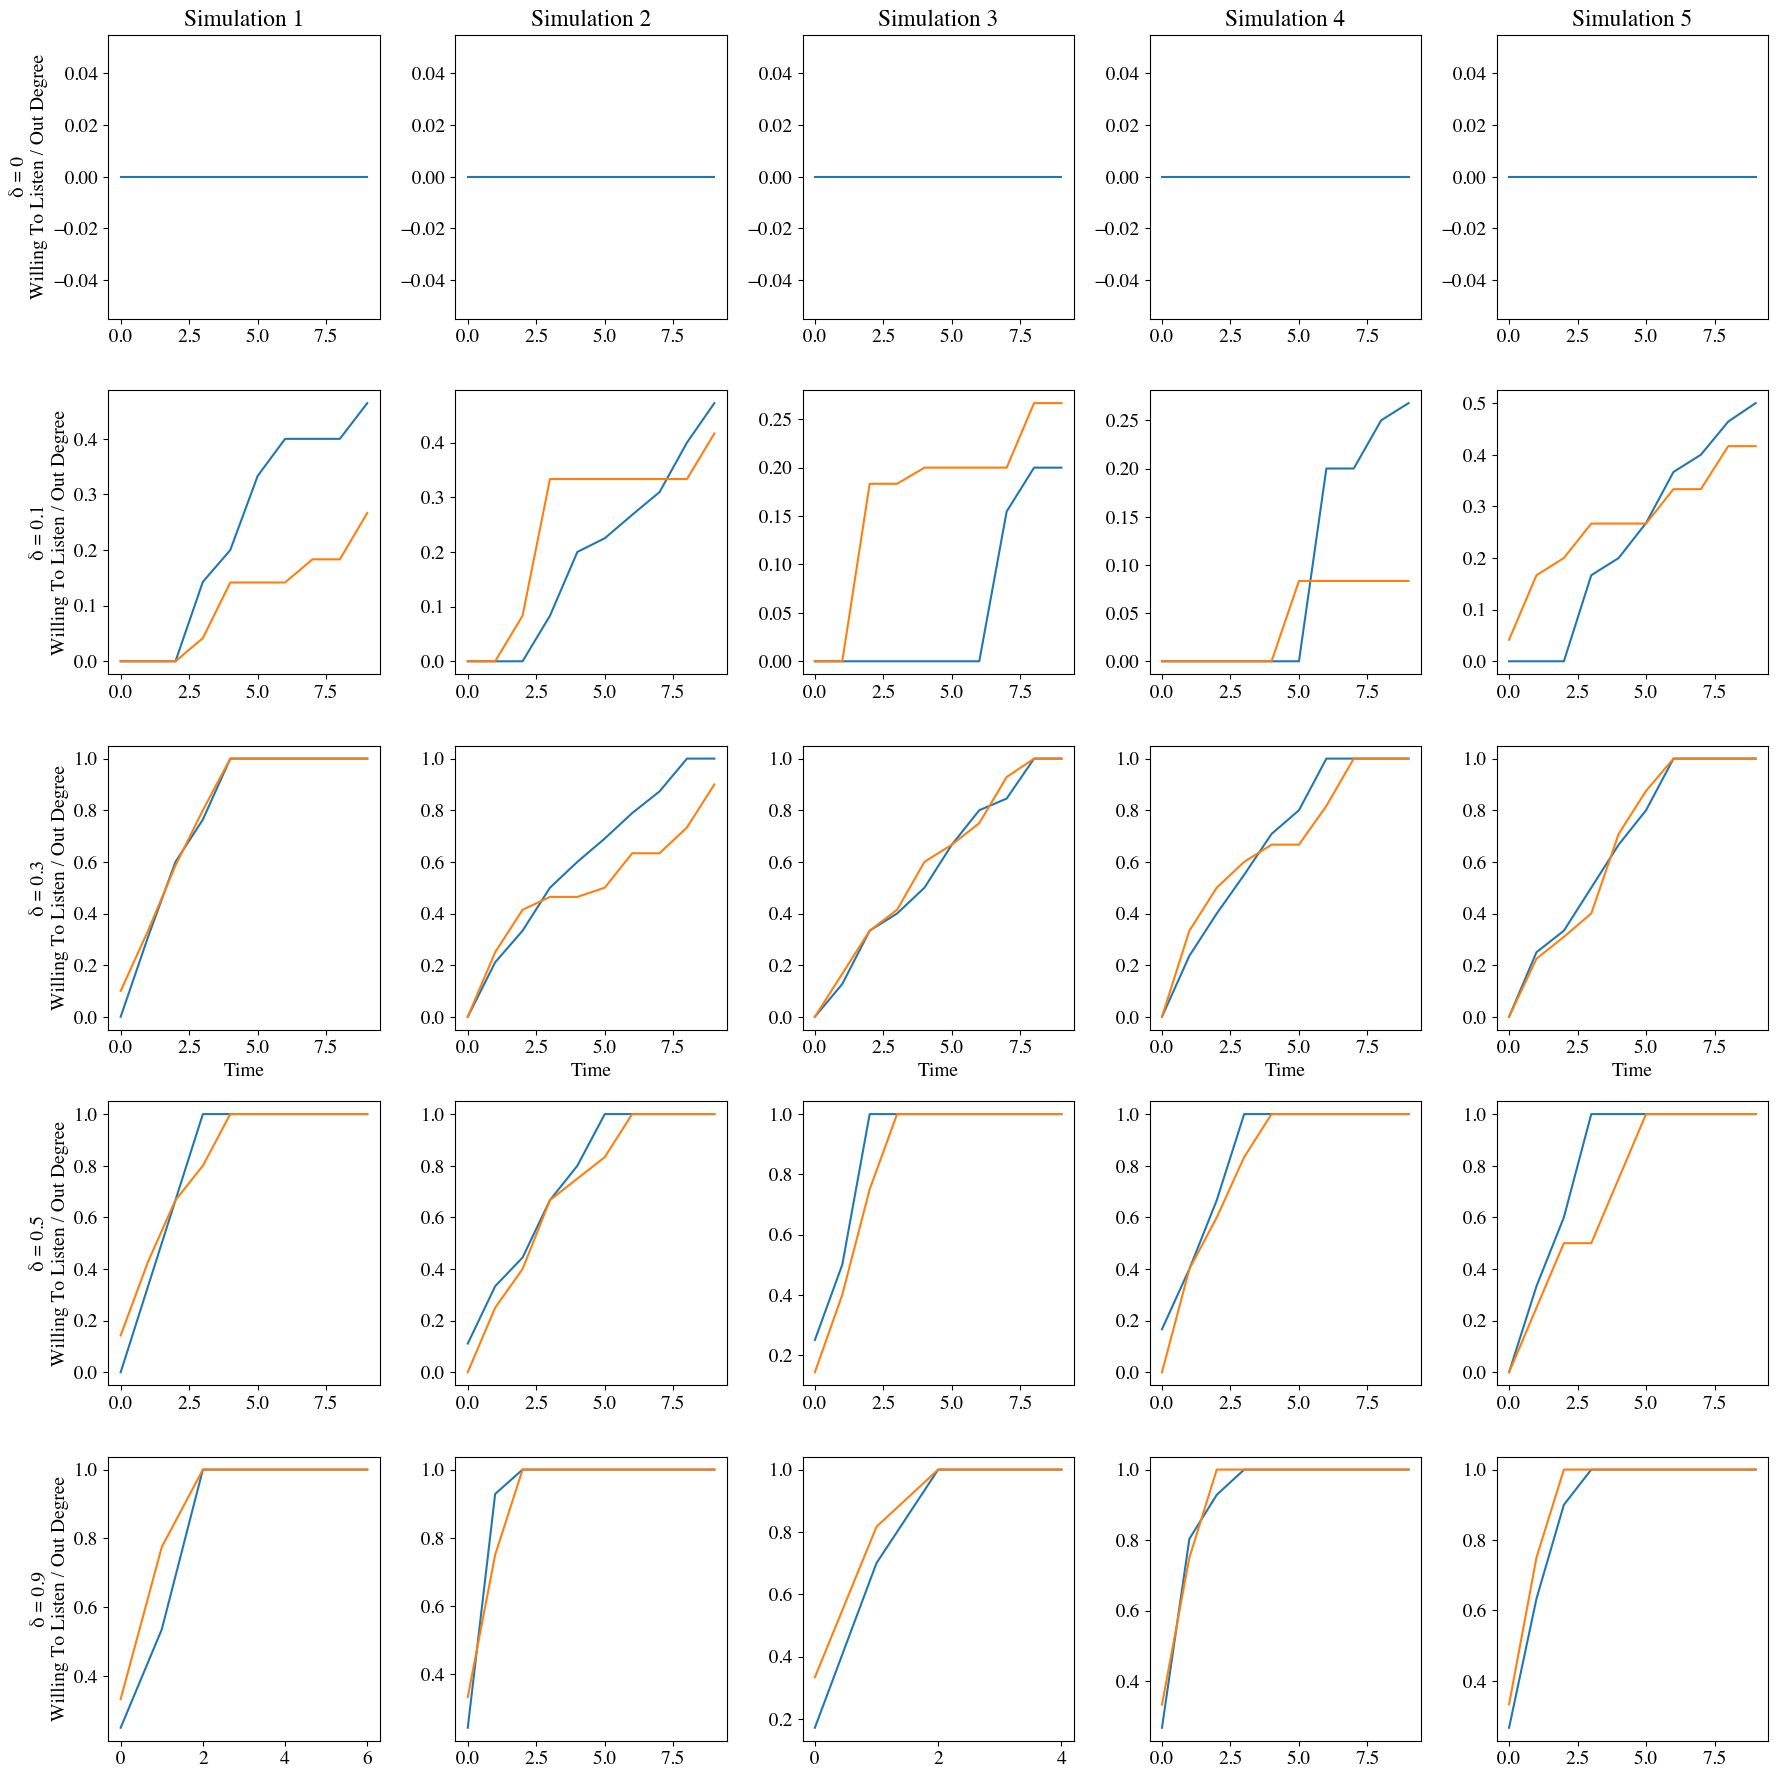

In [314]:
fig,axs = plt.subplots(5,5,figsize=(18,18))

for rc in row_col:
    r = rc[0]
    c = rc[1]
    delta = [0, .1, .3, .5, .9][r]
    
    linkage_analysis = log[delta][c]['linkage_analysis']
    linkage_analysis = pd.DataFrame(linkage_analysis)
    for col in range(N):
        linkage_analysis[col] = linkage_analysis[col].apply(lambda x: x['potential_and_following']/x['out_degree'])
        
    low_temp_agents = np.where(np.array(log[delta][i]['temperature']) <= delta)[0]
    high_temp_agents = np.where(np.array(log[delta][i]['temperature']) > delta)[0]
    
    axs[r][c].plot(linkage_analysis[high_temp_agents].median(axis=1), label='High Temp. Agents')
    axs[r][c].plot(linkage_analysis[low_temp_agents].median(axis=1), label='Low Temp. Agents')
    
    if r == 0:
        axs[r][c].set_title(f'Simulation {c+1}')
    
    if r == 2:
        axs[r][c].set_xlabel('Time')

    if c == 0:
        axs[r][c].set_ylabel(f'δ = {delta}\nWilling To Listen / Out Degree')

fig.tight_layout()
#fig.savefig('../figures/opinions_over_time_dont_listen_if_temp_high.pdf')
fig.show()

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_31867/4238531006.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


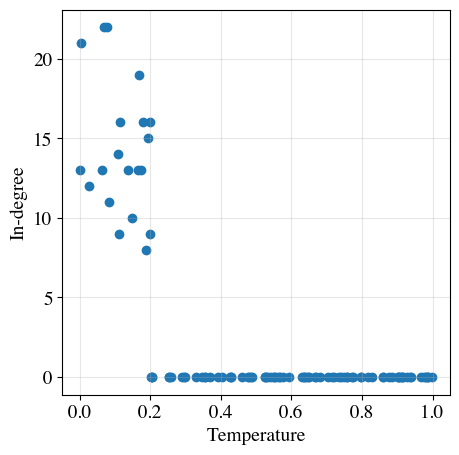

In [135]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(temperatures,
           temp.values())

ax.grid(alpha=.3)

ax.set_xlabel('Temperature')
ax.set_ylabel('In-degree')

fig.show()

### ~~~~~~~~~~~~~~~~~~~~~~~~

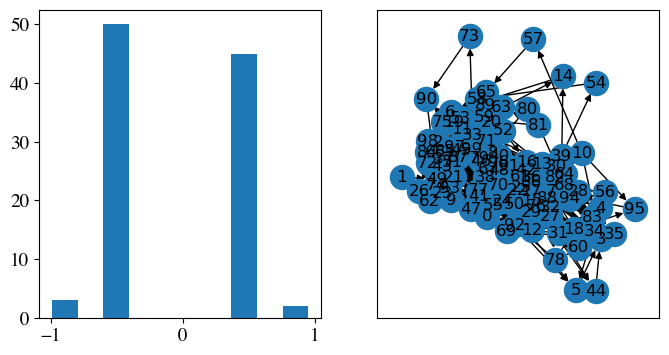

In [202]:
i = 3
d = .1
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].hist(log[d][i]['opinions'])
nx.draw_networkx(log[d][i]['network'], ax=axs[1])

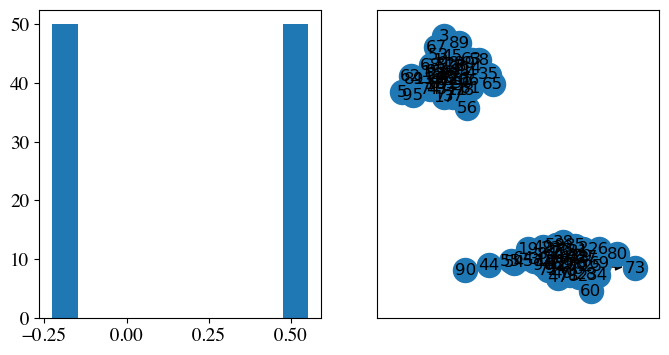

In [200]:
s = 2
d = 1
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].hist(log[d][i]['opinions'], bins=10)
nx.draw_networkx(log[d][i]['network'], ax=axs[1])

In [203]:
sorted([(log[d][s]['network'].in_degree[i],o,t) for i,o,t in zip([*range(100)], log[d][i]['opinions'], log[d][i]['temperature'])])

[(0, -0.4274083150451511, 0.3897692020530047),
 (0, -0.4274083150451511, 0.7882123811079734),
 (0, -0.4274083150451511, 0.8153972087072036),
 (0, -0.42740831504515103, 0.08824301346912722),
 (0, -0.42740831504515103, 0.11590839134780861),
 (0, -0.42740831504515103, 0.15273743944530727),
 (0, -0.42740831504515103, 0.22156936131793215),
 (0, -0.42740831504515103, 0.3817910356038233),
 (0, -0.42740831504515103, 0.38423431451019596),
 (0, -0.42740831504515103, 0.5761933193915515),
 (0, -0.42740831504515103, 0.7032653844196283),
 (0, -0.42740831504515103, 0.7051582649482229),
 (0, -0.42740831504515103, 0.7742907947939045),
 (0, -0.42740831504515103, 0.909976992827271),
 (0, -0.42740831504515103, 0.9315874947942845),
 (0, 0.4772941352806106, 0.6673270834792864),
 (0, 0.47729413528061065, 0.8836787445611232),
 (0, 0.4772941352806107, 0.1132279051511621),
 (0, 0.4772941352806107, 0.35897397590438684),
 (0, 0.4772941352806107, 0.368332628867729),
 (0, 0.4772941352806107, 0.4163500301236043),
 (

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_72216/4273484087.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


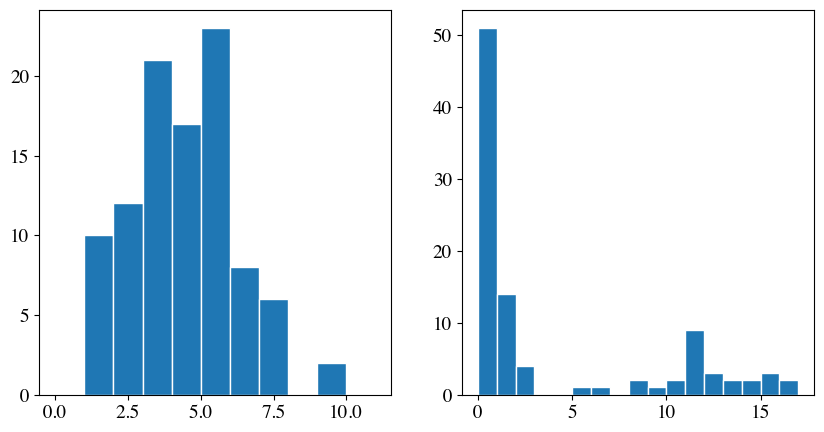

In [140]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].hist([log[0.3][i]['network'].out_degree(j) for j in range(100)], 
         bins=range(max(log[0.3][4]['network'].out_degree(), key=lambda x: x[1])[1]), 
         edgecolor='white')

axs[1].hist([log[0.3][i]['network'].in_degree(j) for j in range(100)], 
         bins=range(max(log[0.3][4]['network'].in_degree(), key=lambda x: x[1])[1]), 
         edgecolor='white')

fig.show()

In [116]:
log[0.3][i]['network'].out_degree(95)

1

In [10]:
log[0][i]['opinions'][91]

0.5256766687245945

In [153]:
row_col = []
for row in range(5):
    for col in range(5):
        row_col.append((row,col))

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_72216/3986953229.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


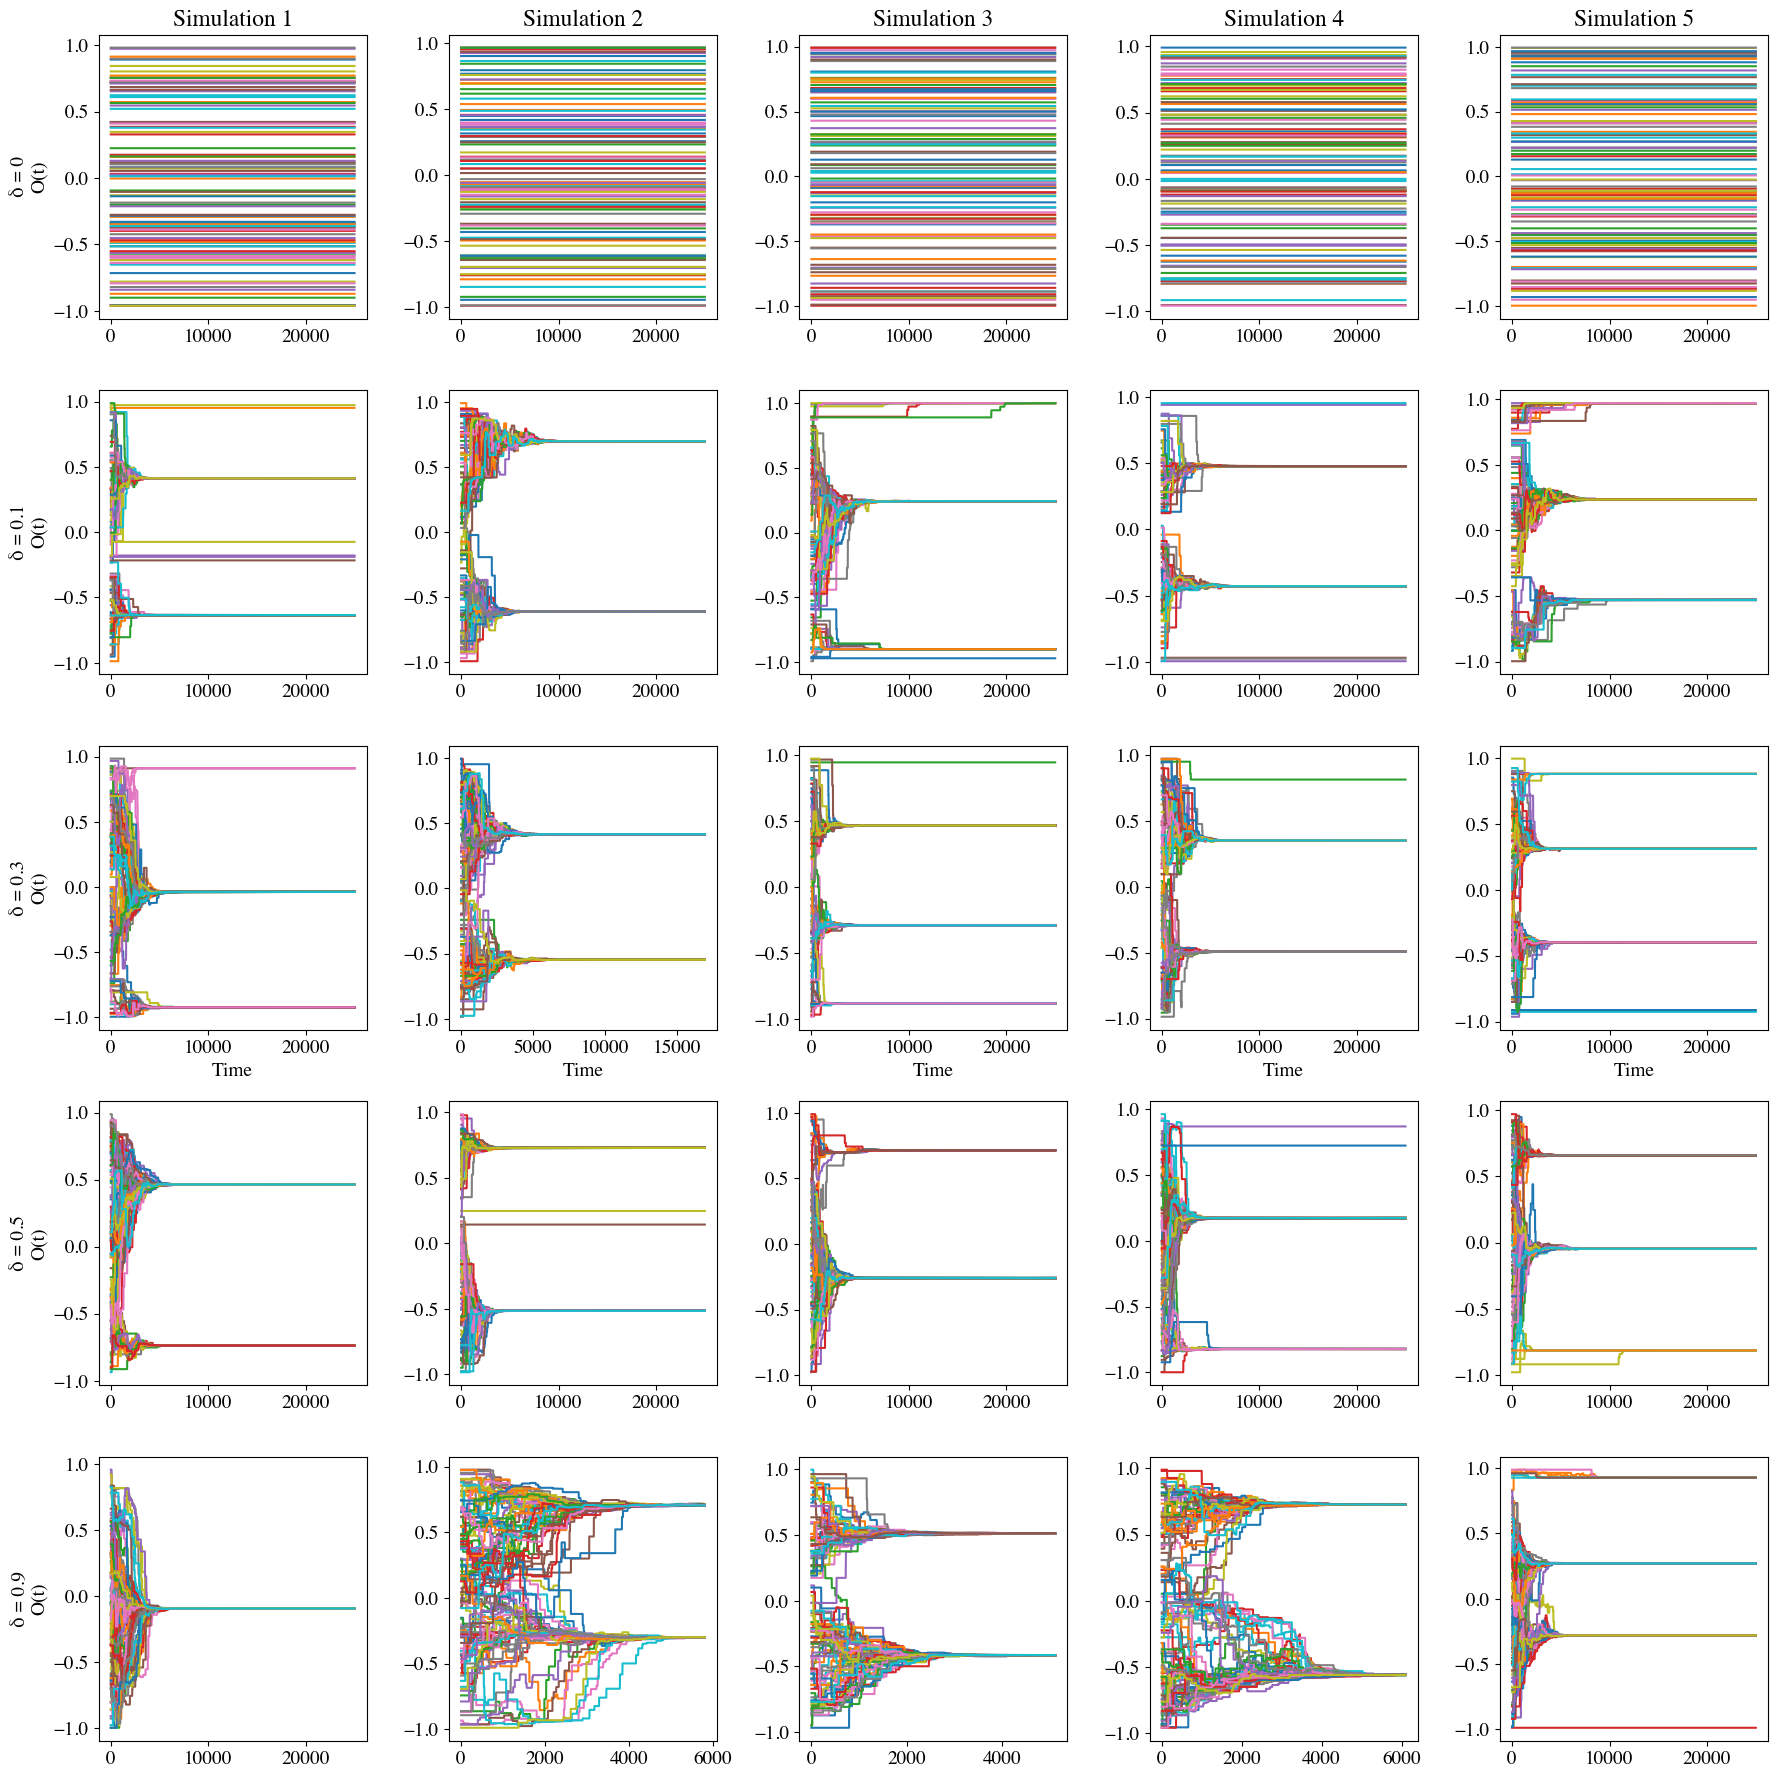

In [155]:
fig,axs = plt.subplots(5,5,figsize=(18,18))

for rc in row_col:
    r = rc[0]
    c = rc[1]
    delta = [0, .1, .3, .5, .9][r]

    for i in range(100):
        axs[r][c].plot([o[i] for o in log[delta][c]['opinion_data']])
        
    if r == 0:
        axs[r][c].set_title(f'Simulation {c+1}')
    
    if r == 2:
        axs[r][c].set_xlabel('Time')

    if c == 0:
        axs[r][c].set_ylabel(f'δ = {delta}\nO(t)')

fig.tight_layout()
#fig.savefig('../figures/opinions_over_time_dont_listen_if_temp_high.pdf')
fig.show()

In [146]:
[(np.mean([np.std(v['opinions']) for v in log[delta].values()]),delta) for delta in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]]

[(0.5624660215854644, 0),
 (0.5298942194431133, 0.1),
 (0.4636040313313382, 0.2),
 (0.4579919172080643, 0.3),
 (0.4909499474646316, 0.4),
 (0.46875817402799014, 0.5),
 (0.4735922514591896, 0.6),
 (0.4910467919084149, 0.7),
 (0.48283685543627675, 0.8),
 (0.4524589481308886, 0.9),
 (0.5100250734144296, 1)]

In [147]:
ratio_of_networks_connected = []
avg_of_stds_in_opinions = []
for delta in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    ratio_of_networks_connected.append(sum([nx.is_connected(log[delta][i]['network'].to_undirected()) for i in range(10)])/10)
    avg_of_stds_in_opinions.append(np.mean([np.std(v['opinions']) for v in log[delta].values()]))
    print(f"For epsilon=.4, delta={delta} --> {100*sum([nx.is_connected(log[delta][i]['network'].to_undirected()) for i in range(10)])/10}% of graphs are connected")

For epsilon=.4, delta=0 --> 100.0% of graphs are connected
For epsilon=.4, delta=0.1 --> 100.0% of graphs are connected
For epsilon=.4, delta=0.2 --> 100.0% of graphs are connected
For epsilon=.4, delta=0.3 --> 80.0% of graphs are connected
For epsilon=.4, delta=0.4 --> 80.0% of graphs are connected
For epsilon=.4, delta=0.5 --> 60.0% of graphs are connected
For epsilon=.4, delta=0.6 --> 40.0% of graphs are connected
For epsilon=.4, delta=0.7 --> 40.0% of graphs are connected
For epsilon=.4, delta=0.8 --> 10.0% of graphs are connected
For epsilon=.4, delta=0.9 --> 20.0% of graphs are connected
For epsilon=.4, delta=1 --> 20.0% of graphs are connected


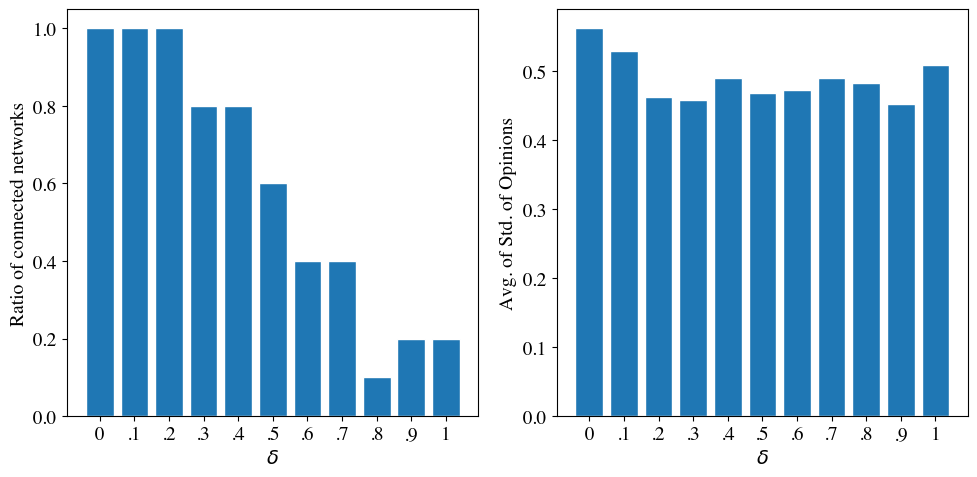

In [148]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
delta_values = ['0','.1','.2','.3','.4','.5','.6','.7','.8','.9','1']

for c, data, ylabel in zip([0,1], 
                           [ratio_of_networks_connected, avg_of_stds_in_opinions],
                           ['Ratio of connected networks', 'Avg. of Std. of Opinions']):
    
    axs[c].bar(delta_values,
               data,
               edgecolor='white')
    axs[c].set_xlabel('$\delta$')
    axs[c].set_ylabel(ylabel)
    
fig.tight_layout()
#plt.savefig('../figures/ratio_of_connected_networks_and_avg_of_std_opinions_if_temp_low.pdf')
plt.show()

In [ ]:
plt.hist()

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_32681/4080423673.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


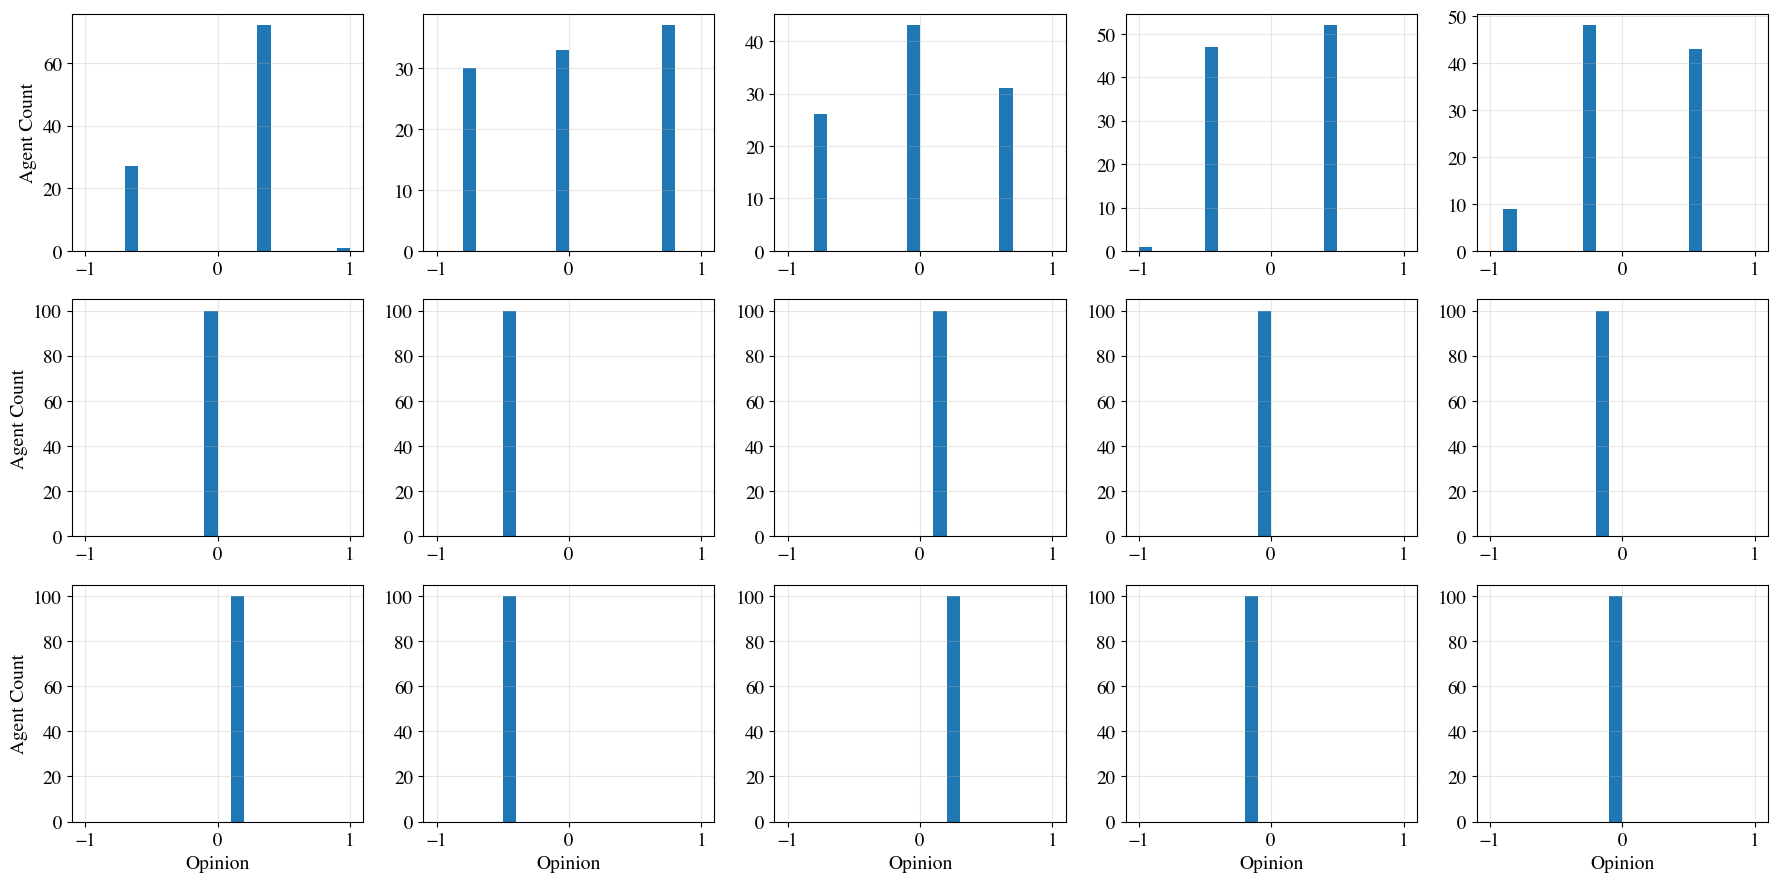

In [244]:
fig,axs = plt.subplots(3,5,figsize=(18,9))

for rc in row_col:
    r = rc[0]
    c = rc[1]
    delta = [0, .1, .3][r]

    axs[r][c].hist(log[delta][c]['opinions'], bins=np.linspace(-1,1,21))
    if c == 0:
        axs[r][c].set_ylabel('Agent Count')
    if r == 2:
        axs[r][c].set_xlabel('Opinion')
    
    axs[r][c].grid(alpha=.3)

fig.tight_layout()
fig.show()

In [343]:
[(np.mean([np.std(v['opinions']) for v in log_epsilon02[delta].values()]),delta) for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]]

[(0.569579133899789, 0.1),
 (0.554107078976028, 0.2),
 (0.5395383883531659, 0.3),
 (0.4666873263226636, 0.4),
 (0.2673878113880138, 0.5),
 (0.11845845059675011, 0.6),
 (0.03254236885416429, 0.7),
 (0.05958975612510701, 0.8),
 (0.002671847659136918, 0.9)]

In [143]:
a = [(np.mean([np.std(v['opinions']) for v in log_epsilon05[delta].values()]),delta) for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]]

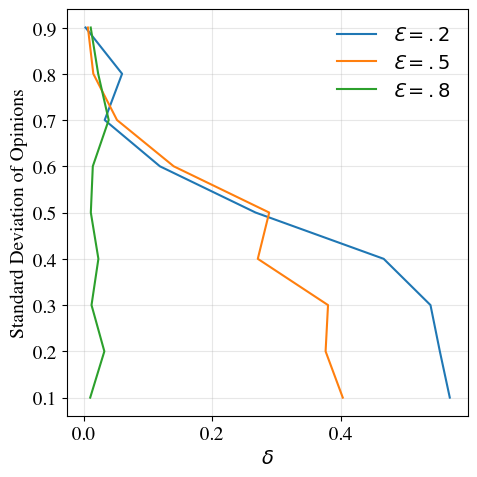

In [172]:
plt.figure(figsize=(5,5))

for col, data, label in zip([0,1,2],[log_epsilon02, log_epsilon05, log_epsilon08],['$Ɛ=.2$','$Ɛ=.5$','$Ɛ=.8$']):

    a = [(np.mean([np.std(v['opinions']) for v in data[delta].values()]),delta) for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]]
    plt.plot([i[0] for i in a],
             [i[1] for i in a],
             label=label)
    plt.grid(alpha=.3)
    plt.xlabel('$δ$')

plt.ylabel('Standard Deviation of Opinions')
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

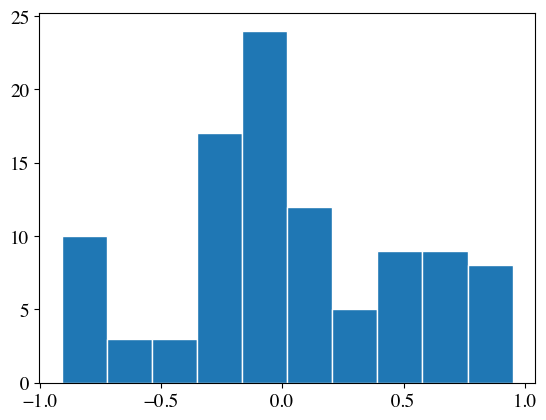

In [48]:
plt.hist([v['opinions'] for v in log_without_tj[.1].values()][9], edgecolor='white')
plt.show()

In [197]:
for delta in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    print(f"For epsilon=.4, delta={delta} --> {100*sum([nx.is_connected(log_without_tj[delta][i]['network'].to_undirected()) for i in range(10)])/10}% of graphs are connected | avg. temp = {np.mean(log_without_tj[delta][i]['temperature'])}")

For epsilon=.4, delta=0 --> 30.0% of graphs are connected | avg. temp = 0.5150456343626314
For epsilon=.4, delta=0.1 --> 100.0% of graphs are connected | avg. temp = 0.5227687388981012
For epsilon=.4, delta=0.2 --> 90.0% of graphs are connected | avg. temp = 0.4749226269227784
For epsilon=.4, delta=0.3 --> 100.0% of graphs are connected | avg. temp = 0.5089149369581497
For epsilon=.4, delta=0.4 --> 100.0% of graphs are connected | avg. temp = 0.49731527020212907
For epsilon=.4, delta=0.5 --> 90.0% of graphs are connected | avg. temp = 0.5385943979149203
For epsilon=.4, delta=0.6 --> 100.0% of graphs are connected | avg. temp = 0.5351165573288356
For epsilon=.4, delta=0.7 --> 100.0% of graphs are connected | avg. temp = 0.4654590721148926
For epsilon=.4, delta=0.8 --> 100.0% of graphs are connected | avg. temp = 0.49446056428134466
For epsilon=.4, delta=0.9 --> 100.0% of graphs are connected | avg. temp = 0.43964476677996794
For epsilon=.4, delta=1 --> 100.0% of graphs are connected | a

In [327]:
for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    print(f"For epsilon=.2, delta={delta} --> {100*sum([nx.is_connected(log_epsilon02[delta][i]['network'].to_undirected()) for i in range(10)])/10}% of graphs are connected | avg. temp = {np.mean(log_epsilon02[delta][i]['temperature'])}")

For epsilon=.2, delta=0.1 --> 40.0% of graphs are connected | avg. temp = 0.4132758397528598
For epsilon=.2, delta=0.2 --> 80.0% of graphs are connected | avg. temp = 0.5570542589724754
For epsilon=.2, delta=0.3 --> 70.0% of graphs are connected | avg. temp = 0.42739294943441963
For epsilon=.2, delta=0.4 --> 80.0% of graphs are connected | avg. temp = 0.38020992946047
For epsilon=.2, delta=0.5 --> 90.0% of graphs are connected | avg. temp = 0.5307309029838208
For epsilon=.2, delta=0.6 --> 90.0% of graphs are connected | avg. temp = 0.26343390264129424
For epsilon=.2, delta=0.7 --> 100.0% of graphs are connected | avg. temp = 0.3362608198932177
For epsilon=.2, delta=0.8 --> 100.0% of graphs are connected | avg. temp = 0.3486893232283188
For epsilon=.2, delta=0.9 --> 100.0% of graphs are connected | avg. temp = 0.365140131752855


In [324]:
for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    print(f"For epsilon=.5, delta={delta} --> {100*sum([nx.is_connected(log_epsilon05[delta][i]['network'].to_undirected()) for i in range(10)])/10}% of graphs are connected | avg. temp = {np.mean(log_epsilon05[delta][i]['temperature'])}")

For epsilon=.5, delta=0.1 --> 20.0% of graphs are connected | avg. temp = 0.3288037205044777
For epsilon=.5, delta=0.2 --> 30.0% of graphs are connected | avg. temp = 0.43610271800542577
For epsilon=.5, delta=0.3 --> 30.0% of graphs are connected | avg. temp = 0.4134624056264666
For epsilon=.5, delta=0.4 --> 70.0% of graphs are connected | avg. temp = 0.4871511643435116
For epsilon=.5, delta=0.5 --> 40.0% of graphs are connected | avg. temp = 0.4269942662757057
For epsilon=.5, delta=0.6 --> 90.0% of graphs are connected | avg. temp = 0.44594938156523223
For epsilon=.5, delta=0.7 --> 90.0% of graphs are connected | avg. temp = 0.4620468768702349
For epsilon=.5, delta=0.8 --> 100.0% of graphs are connected | avg. temp = 0.5060033801718049
For epsilon=.5, delta=0.9 --> 100.0% of graphs are connected | avg. temp = 0.5325872283057713


In [325]:
for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    print(f"For epsilon=.8, delta={delta} --> {100*sum([nx.is_connected(log_epsilon08[delta][i]['network'].to_undirected()) for i in range(10)])/10}% of graphs are connected | avg. temp = {np.mean(log_epsilon08[delta][i]['temperature'])}")

For epsilon=.8, delta=0.1 --> 100.0% of graphs are connected | avg. temp = 0.33891595327022367
For epsilon=.8, delta=0.2 --> 100.0% of graphs are connected | avg. temp = 0.36728456024106243
For epsilon=.8, delta=0.3 --> 100.0% of graphs are connected | avg. temp = 0.3929697219393058
For epsilon=.8, delta=0.4 --> 90.0% of graphs are connected | avg. temp = 0.44935467699101594
For epsilon=.8, delta=0.5 --> 100.0% of graphs are connected | avg. temp = 0.43184660461250396
For epsilon=.8, delta=0.6 --> 100.0% of graphs are connected | avg. temp = 0.45670529861254827
For epsilon=.8, delta=0.7 --> 90.0% of graphs are connected | avg. temp = 0.47366386312707376
For epsilon=.8, delta=0.8 --> 90.0% of graphs are connected | avg. temp = 0.49305949618796924
For epsilon=.8, delta=0.9 --> 100.0% of graphs are connected | avg. temp = 0.5488231854153152


(array([11.,  0.,  0., 27.,  0., 31.,  0.,  0., 28.,  3.]),
 array([-0.92257493, -0.73292641, -0.54327788, -0.35362936, -0.16398083,
         0.02566769,  0.21531622,  0.40496474,  0.59461327,  0.78426179,
         0.97391032]),
 <BarContainer object of 10 artists>)

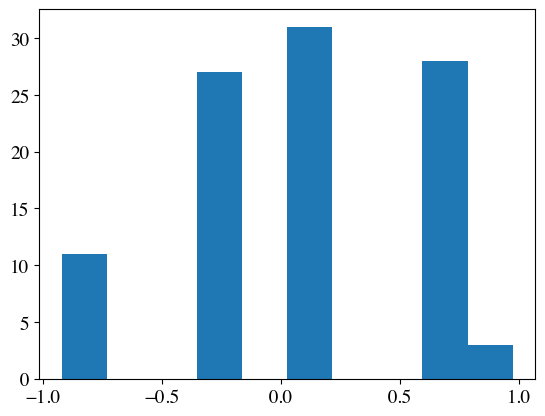

In [319]:
plt.hist(log_epsilon02[0.4][5]['opinions'])

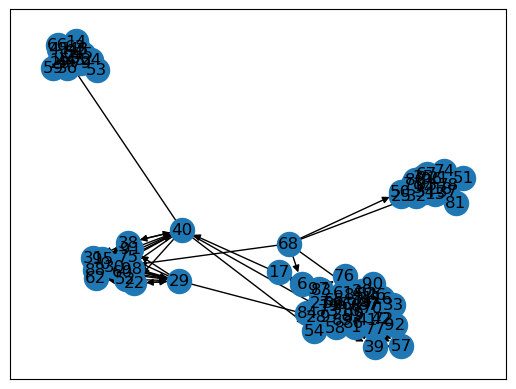

In [328]:
nx.draw_networkx(log_epsilon02[0.2][5]['network'])

False

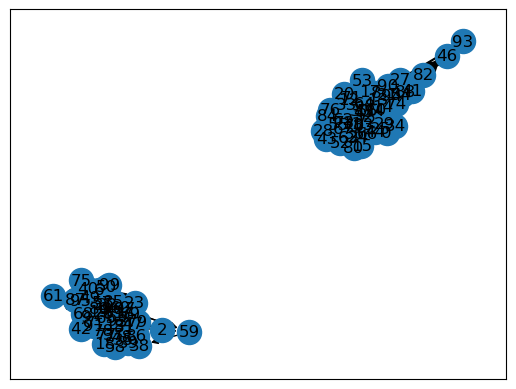

In [260]:
i = 0
nx.draw_networkx(log_epsilon05[.4][i]['network'])
a = log_epsilon05[.5][i]['network'].copy()
nx.is_connected(a.to_undirected())

In [173]:
[(np.mean([np.std(v['opinions']) for v in log_epsilon05[delta].values()]),delta) for delta in [.1,.2,.3,.4,.5,.6,.7,.8,.9]]

[(0.40304086211763873, 0.1),
 (0.3763070043781066, 0.2),
 (0.3800835020958208, 0.3),
 (0.27079832842153206, 0.4),
 (0.28854905978732714, 0.5),
 (0.13992588540789658, 0.6),
 (0.05168397840051474, 0.7),
 (0.014818884919152096, 0.8),
 (0.0063993169493762655, 0.9)]

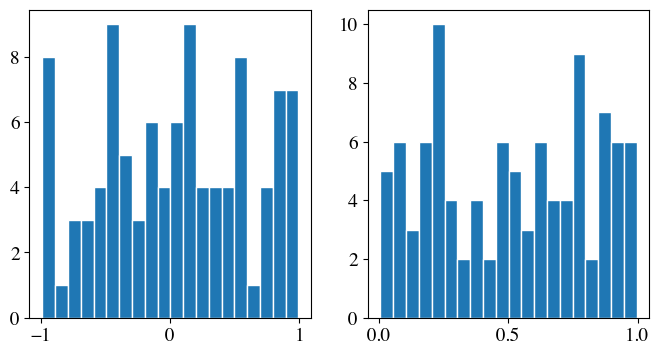

In [92]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].hist([ecd.agents[i].opinion for i in range(100)], bins=20, edgecolor='white')
axs[1].hist([ecd.agents[i].temperature for i in range(100)], bins=20, edgecolor='white')
plt.show()

In [93]:
t_max = 15000
mu = .5
p = .5
q = .5
beta = .5
magnitude = .8
ratio_affected_agents = .2
rewiring_methods = ['Random']

ecd.evolve(t_max, mu, p, q, beta, magnitude, ratio_affected_agents, rewiring_methods)

Iteration: 0
Avg. temp: 0.5089593655193714
Std. temp: 0.3008154329446614
Avg. opinion: 0.047837676418621584
Std. opinion: 0.5715738962027038
Iteration: 500
Avg. temp: 0.4786977716865807
Std. temp: 0.0894724929259558
Avg. opinion: 0.04941536726227594
Std. opinion: 0.5629333304016774
Iteration: 1000
Avg. temp: 0.4599812221351566
Std. temp: 0.02934861331422729
Avg. opinion: 0.057997437567114785
Std. opinion: 0.5699972331612958
Iteration: 1500
Avg. temp: 0.4610340799210773
Std. temp: 0.011779567393872696
Avg. opinion: 0.06467142550053859
Std. opinion: 0.5724538390981383
Iteration: 2000
Avg. temp: 0.4642401680331713
Std. temp: 0.007174075976465587
Avg. opinion: 0.0640681240238301
Std. opinion: 0.5785231429323456
Iteration: 2500
Avg. temp: 0.46545448594541555
Std. temp: 0.0033539950443901663
Avg. opinion: 0.07087113463813084
Std. opinion: 0.5833849593534902
Iteration: 3000
Avg. temp: 0.4663600688362363
Std. temp: 0.002236580993408976
Avg. opinion: 0.06830366193109574
Std. opinion: 0.58122027

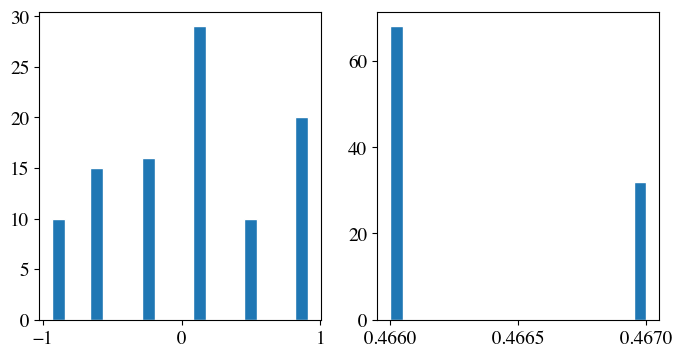

In [94]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].hist([ecd.agents[i].opinion for i in range(100)], bins=20, edgecolor='white')
axs[1].hist([round(ecd.agents[i].temperature,3) for i in range(100)], bins=20, edgecolor='white')
plt.show()

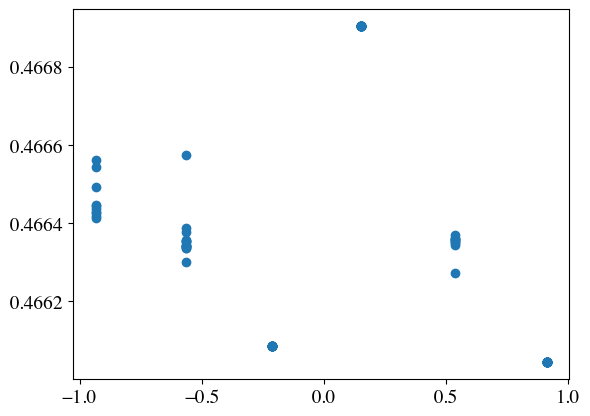

In [95]:
plt.scatter([a.opinion for a in ecd.agents],
            [a.temperature for a in ecd.agents])

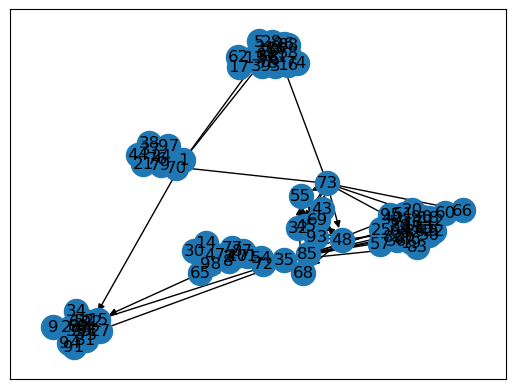

In [96]:
nx.draw_networkx(ecd.social_media.G)